In [2]:
import sys
sys.path.append('../../')

import acalib
import acalib.stacking.main as st 
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.segmentation import clear_border
import numpy as np
%matplotlib inline

from skimage.measure import regionprops
import glob
import scipy.ndimage as scnd

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [37]:
def img_props(path, data=[]):
    
    img =  fits.open(path, ignore_missing_end = True )[0].data

    flt = threshold_otsu(img)
    otsu = img >= flt
    clr = clear_border(otsu)

    # label image regions
    label_image, nlabel = label(clr, return_num = True)
    borders = np.logical_xor(otsu, clr)
    label_image[borders] = -1

    props = regionprops(label_image)

    ratios = []
    areas = []

    for i in props:
        ratios.append(i.minor_axis_length/i.major_axis_length)
        areas.append(i.area)

    if len(props) > 1:
        pos = areas.index(max(areas))
    else:
        pos = 0
    
    properties = {'centroid': props[pos].centroid, 'major': props[pos].major_axis_length,
            'minor': props[pos].minor_axis_length, 'ratio': ratios[pos], 
            'angle': props[pos].orientation, 'area': props[pos].area, 'img': props[pos].image,
                 'clr': clr, 'label': label_image, 'orig': img}
    
    return properties


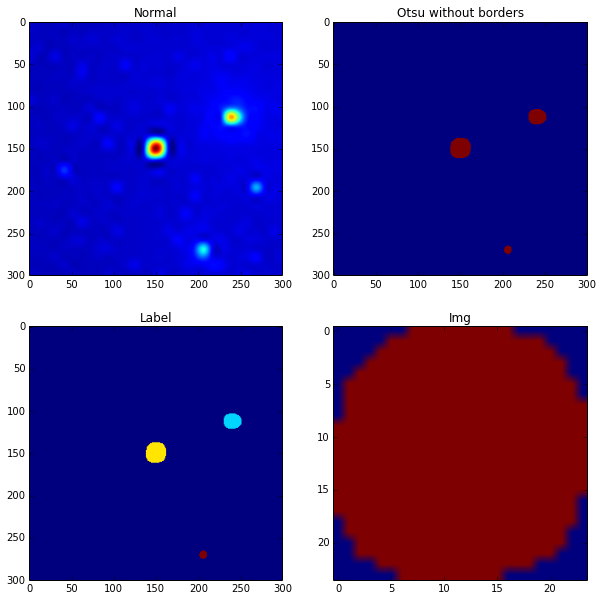

In [39]:
tprops = img_props('fb2/M97-dss2b.fits')

fig = plt.figure(figsize =(10,10))
ax = fig.add_subplot(2,2,1)
ax.set_title('Normal')
ax.imshow(tprops['orig'])

ax = fig.add_subplot(2,2,2)
ax.set_title('Otsu without borders')
ax.imshow(tprops['clr'])

ax = fig.add_subplot(2,2,3)
ax.set_title('Label')
ax.imshow(tprops['label'])

ax = fig.add_subplot(2,2,4)
ax.set_title('Img')
ax.imshow(tprops['img'])



plt.show()



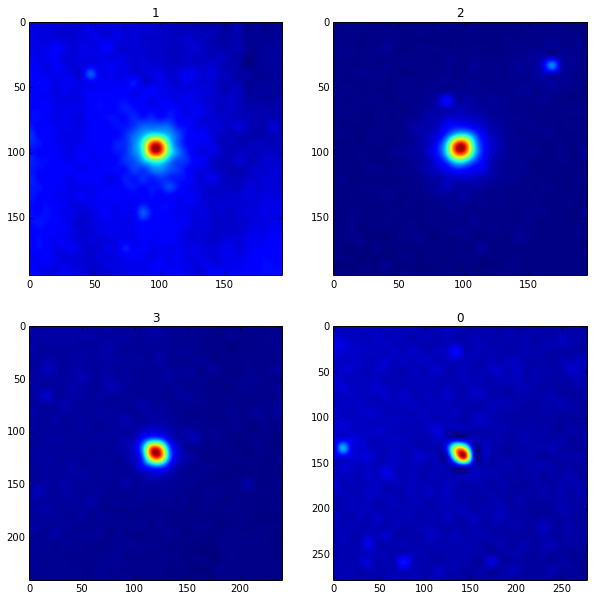

In [40]:
inputDir = 'test'
data = glob.glob(inputDir+'/*.fits')
arrays = []

for i in np.arange(len(data)):
    prop = img_props(data[i])
    scale = tprops['major']/prop['major']
    zoom = scnd.zoom(prop['orig'],scale)
    arrays.append(zoom)
    
fig2 = plt.figure(figsize =(10,10))
for i in np.arange(len(arrays)):
    ax = fig2.add_subplot(2,2,i)
    ax.set_title(str(i))
    ax.imshow(arrays[i])

plt.show()    

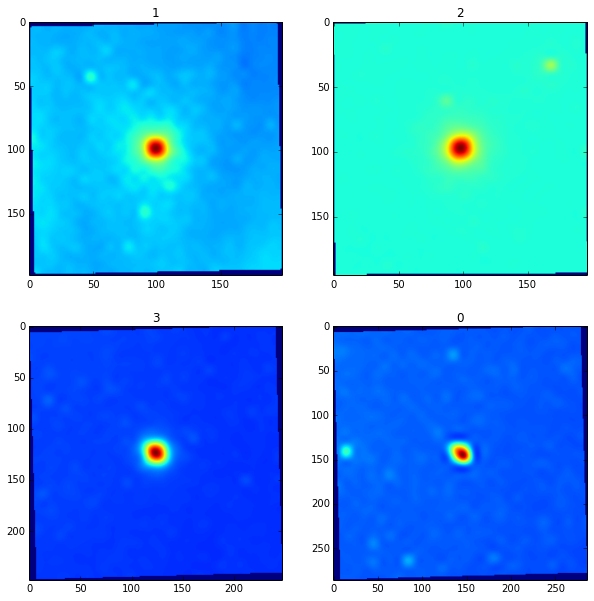

In [41]:
ar2 = []
for i in np.arange(len(data)):
    prop = img_props(data[i])
    angle  = tprops['angle'] - prop['angle']
    rotated = scnd.rotate(arrays[i], angle, reshape = True)
    ar2.append(rotated)
    
fig2 = plt.figure(figsize =(10,10))
for i in np.arange(len(ar2)):
    ax = fig2.add_subplot(2,2,i)
    ax.set_title(str(i))
    ax.imshow(ar2[i])

plt.show()  


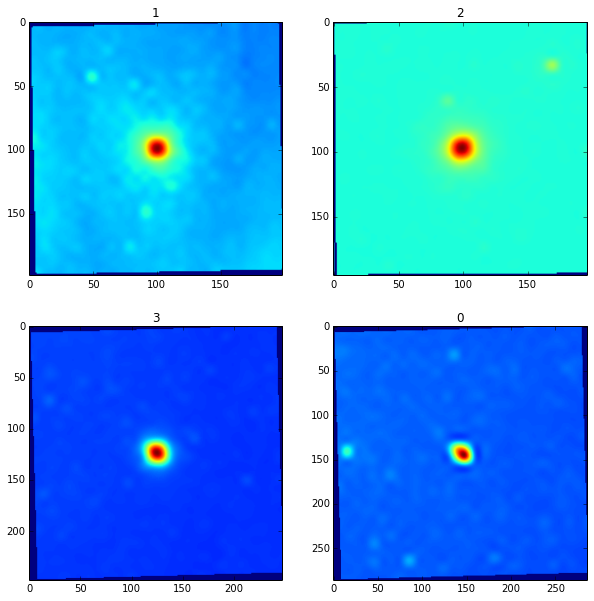

In [42]:
#A

ar3 = []
for i in np.arange(len(data)):
    prop = img_props(data[i])
    size  = tprops['orig'].shape
    centroid = tprops['centroid']

    rowsToShift = int(round(size[0]/2 - centroid[0]))
    columnsToShift = int(round(size[1]/2 - centroid[1]))
    img = ar2[i]
    
    if rowsToShift!= 0:
        img = np.roll(img, rowsToShift)
    elif columnsToShift != 0:
        shifted = np.roll(img, columnsToShift)
        
    ar3.append(shifted)
    
fig2 = plt.figure(figsize =(10,10))
for i in np.arange(len(ar3)):
    ax = fig2.add_subplot(2,2,i)
    ax.set_title(str(i))
    ax.imshow(ar3[i])

plt.show()

In [36]:
#CROP

for i in np.arange(len(ar3)):
    ax = fig2.add_subplot(2,2,i)
    ax.set_title(str(i))
    ax.imshow(ar3[i])

plt.show()

ValueError: total size of new array must be unchanged